In [111]:
import torch
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
from useful_functions_pytorch import *
from optimizer_pytorch import *
from model import *
from real_data_process import *
import matplotlib.pyplot as plt

In [112]:
import importlib
import optimizer_pytorch
importlib.reload(optimizer_pytorch)
from optimizer_pytorch import *

In [113]:
def get_B(A,u,n):
    v=np.ones(n)
    for _ in range(u):
        v=A.T@v
    v1=A.T@v
    return np.diag(v)@A@np.diag(1/v1)

In [114]:
m = loadmat('MNIST_digits_2_4.mat')
X_train = m['X_train']
y_train = m['y_train'].transpose().reshape(-1)
X_test = m["X_test"]
y_test = m["y_test"].transpose().reshape(-1)
y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

n=1
d=784
L=12432
A=get_xinmeng_like_matrix(n,seed=42).T
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A=R
B=I#get_B(A,u=9,n=n)
nodes_data = distribute_data(X=X_train, y=y_train, n_nodes=n)
h = np.stack([i for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L, d) 形状的数组
y = np.stack([j for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L) 形状的数组

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(A, dtype=torch.float32).to(device)
B = torch.tensor(B, dtype=torch.float32).to(device)
h_data = torch.tensor(h, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(h_data.size())

torch.Size([1, 12432, 784])


简单版本，说明不是data的问题

In [115]:
criterion=nn.BCELoss()
model=SimpleNN()
optimizer=torch.optim.Adam(params=model.parameters(),lr=1e-4)
for epoch in range(200):  # 10 epochs
    model.train()
    images,labels=h_data[0],y_data[0]
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs.view(-1), labels)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
model.eval()
correct = 0
total = 0

with torch.no_grad():
    images,labels=X_test_tensor,y_test_tensor
    outputs = model(images)
    predicted = (outputs > 0.5).float().view(-1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Epoch 1, Loss: 0.6926
Epoch 2, Loss: 0.6923
Epoch 3, Loss: 0.6920
Epoch 4, Loss: 0.6917
Epoch 5, Loss: 0.6914
Epoch 6, Loss: 0.6911
Epoch 7, Loss: 0.6908
Epoch 8, Loss: 0.6905
Epoch 9, Loss: 0.6902
Epoch 10, Loss: 0.6898
Epoch 11, Loss: 0.6895
Epoch 12, Loss: 0.6892
Epoch 13, Loss: 0.6888
Epoch 14, Loss: 0.6885
Epoch 15, Loss: 0.6881
Epoch 16, Loss: 0.6877
Epoch 17, Loss: 0.6873
Epoch 18, Loss: 0.6869
Epoch 19, Loss: 0.6865
Epoch 20, Loss: 0.6861
Epoch 21, Loss: 0.6856
Epoch 22, Loss: 0.6852
Epoch 23, Loss: 0.6847
Epoch 24, Loss: 0.6842
Epoch 25, Loss: 0.6836
Epoch 26, Loss: 0.6831
Epoch 27, Loss: 0.6825
Epoch 28, Loss: 0.6819
Epoch 29, Loss: 0.6813
Epoch 30, Loss: 0.6807
Epoch 31, Loss: 0.6800
Epoch 32, Loss: 0.6794
Epoch 33, Loss: 0.6787
Epoch 34, Loss: 0.6780
Epoch 35, Loss: 0.6772
Epoch 36, Loss: 0.6765
Epoch 37, Loss: 0.6757
Epoch 38, Loss: 0.6749
Epoch 39, Loss: 0.6741
Epoch 40, Loss: 0.6732
Epoch 41, Loss: 0.6724
Epoch 42, Loss: 0.6715
Epoch 43, Loss: 0.6706
Epoch 44, Loss: 0.66

In [116]:
torch.manual_seed(40)
model_list=[SimpleNN() for _ in range(n)]
criterion=nn.BCELoss()

In [117]:
def closure():
    total_loss=0
    for i,model in enumerate(model_list):
        for param in model.parameters():
            param.requires_grad = True
        model.zero_grad()
        output=model(h_data[i])
        loss=criterion(output.view(-1),y_data[i])
        loss.backward()
        total_loss+=loss.item()
    return total_loss/(len(model_list))

def compute_accuracy(model_list, X_test, y_test):
    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for i, model in enumerate(model_list):
            outputs = model(X_test)
            predicted = (outputs > 0.5).float().view(-1) # 二分类的阈值设置为0.5
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy

Epoch [1], Loss: 0.6934574246, Accuracy: 48.5528219971%
Epoch [2], Loss: 0.6933524013, Accuracy: 48.5528219971%
Epoch [3], Loss: 0.6932505965, Accuracy: 48.5528219971%
Epoch [4], Loss: 0.6931533217, Accuracy: 48.5528219971%
Epoch [5], Loss: 0.6930605769, Accuracy: 48.5528219971%
Epoch [6], Loss: 0.6929718852, Accuracy: 48.5528219971%
Epoch [7], Loss: 0.6928864121, Accuracy: 48.5528219971%
Epoch [8], Loss: 0.6928039193, Accuracy: 48.5528219971%
Epoch [9], Loss: 0.6927240491, Accuracy: 48.5528219971%
Epoch [10], Loss: 0.6926460266, Accuracy: 48.5528219971%
Epoch [11], Loss: 0.6925699115, Accuracy: 48.5528219971%
Epoch [12], Loss: 0.6924952865, Accuracy: 48.5528219971%
Epoch [13], Loss: 0.6924217939, Accuracy: 48.5528219971%
Epoch [14], Loss: 0.6923493743, Accuracy: 48.5528219971%
Epoch [15], Loss: 0.6922776103, Accuracy: 48.5528219971%
Epoch [16], Loss: 0.6922063828, Accuracy: 48.5528219971%
Epoch [17], Loss: 0.6921355128, Accuracy: 48.5528219971%
Epoch [18], Loss: 0.6920648217, Accuracy

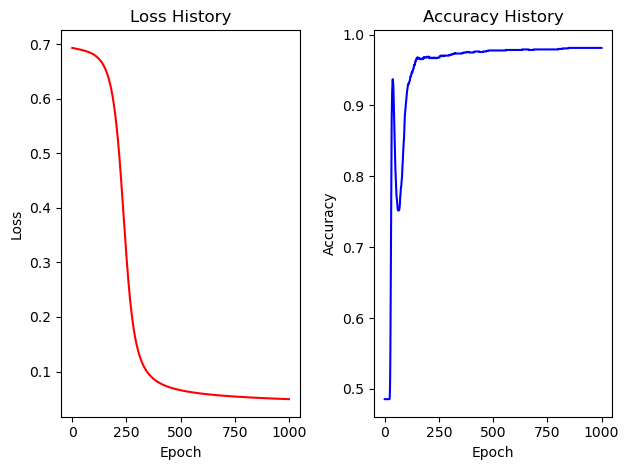

In [118]:
criterion = nn.BCELoss()
optimizer = PullSum(model_list=model_list, lr=0.1, A=A, B=B,closure=closure)
loss_history,accuracy_hostory=[],[]
for epoch in range(1000):  # 假设训练10个epoch
    loss = optimizer.step(closure)  # 调用优化器的 step 方法，并传入 closure
    loss_history.append(loss)
    accuracy = compute_accuracy(model_list, X_test_tensor, y_test_tensor)  # 计算测试集上的准确率
    accuracy_hostory.append(accuracy)
    # 输出当前 epoch 的损失和准确率
    print(f"Epoch [{epoch + 1}], Loss: {loss:.10f}, Accuracy: {100*accuracy:.10f}%")
plt.subplot(1, 2, 1)  # 1行2列的第1张图
plt.plot(loss_history, color='r')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制准确率
plt.subplot(1, 2, 2)  # 1行2列的第2张图
plt.plot(accuracy_hostory, color='b')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 显示图像
plt.tight_layout()
plt.show()